In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import numpy as np
import math

device = 'cuda'

batch_size = 256

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomRotation(degrees=(-45, 45)),
#     transforms.ColorJitter(brightness=.5,hue=0.5), # 改变图像的亮度和饱和度
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, pin_memory=True, num_workers=4)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size*2,
                                         shuffle=False, pin_memory=True, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


# SK-Net

In [3]:
class SKConv(nn.Module):
    def __init__(self, features, M=2, G=32, r=16, stride=1, L=32):
        super(SKConv, self).__init__()
        
        d = max(int(features/r), L)
        self.M = M
        self.features = features
        
        self.convs = nn.ModuleList([])
        for i in range(M):
            self.convs.append(nn.Sequential(
                nn.Conv2d(features, features, kernel_size=3, stride=stride,
                          padding=1+i, dilation=1+i, groups=G, bias=False),
                nn.BatchNorm2d(features),
                nn.ReLU(True)
            ))
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Conv2d(features, d, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(d),
            nn.ReLU(True)
        )
        self.fcs = nn.ModuleList([])
        for i in range(M):
            self.fcs.append(
                nn.Conv2d(d, features, kernel_size=1, stride=1)
            )
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        batch_size = x.shape[0]
        
        feats = [conv(x) for conv in self.convs]
        feats = torch.cat(feats, dim=1)
        feats = feats.view(batch_size, self.M, self.features, feats.shape[2], feats.shape[3])
        
        feats_U = torch.sum(feats, dim=1)
        feats_S = self.gap(feats_U)
        feats_Z = self.fc(feats_S)
        
        attention = [fc(feats_Z) for fc in self.fcs]
        attention = torch.cat(attention, dim=1)
        attention = attention.view(batch_size, self.M, self.features, 1, 1)
        attention = self.softmax(attention)
        
        feats_V = torch.sum(feats * attention, dim=1)
        return feats_V
    
    
class SKUnit(nn.Module):
    def __init__(self, in_features, middle_features, out_features, M=2, G=32, r=16, stride=1, L=32):
        super(SKUnit, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_features, middle_features, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(middle_features),
            nn.ReLU(True)
        )
        self.conv2_sk = SKConv(middle_features, M, G, r, stride, L)
        self.conv3 = nn.Sequential(
            nn.Conv2d(middle_features, out_features, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_features)
        )
        
        if in_features == out_features:
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_features, out_features, 1, stride, bias=False),
                nn.BatchNorm2d(out_features)
            )
        
        self.relu = nn.ReLU(True)
        
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.conv2_sk(out)
        out = self.conv3(out)
        out = self.relu(out + self.shortcut(identity))
        return out
    
class SKNet(nn.Module):
    def __init__(self, num_classes, block_config, strides_list=[1, 2, 2, 2]):
        super(SKNet, self).__init__()
        self.basic_conv = nn.Sequential(
            nn.Conv2d(3, 64, 7, 2, 3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )
        
        self.maxpool = nn.MaxPool2d(3, 2, 1)
        
        self.stage_1 = self.make_layer(64, 128, 256, num_blocks=block_config[0], stride=strides_list[0])
        self.stage_2 = self.make_layer(256, 256, 512, num_blocks=block_config[1], stride=strides_list[1])
        self.stage_3 = self.make_layer(512, 512, 1024, num_blocks=block_config[2], stride=strides_list[2])
        self.stage_4 = self.make_layer(1024, 1024, 2048, num_blocks=block_config[3], stride=strides_list[3])
        
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(2048, num_classes)
        
    def make_layer(self, in_features, middle_features, out_features, num_blocks, stride=1):
        layers = [SKUnit(in_features, middle_features, out_features, stride)]
        for _ in range(1, num_blocks):
            layers.append(SKUnit(out_features, middle_features, out_features))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.basic_conv(x)
        out = self.maxpool(out)
        out = self.stage_1(out)
        out = self.stage_2(out)
        out = self.stage_3(out)
        out = self.stage_4(out)
        out = self.gap(out)
        out = torch.squeeze(out)
        out = self.classifier(out)
        return out

    
def SKNet26(num_classes=100):
    return SKNet(num_classes, [2,2,2,2])

def SKNet50(num_classes=100):
    return SKNet(num_classes, [3,4,6,3])

In [4]:
model = SKNet50().to(device)
max_lr = 0.1
epochs = 200
# warm_up_epochs = 5
# max_warm_up_lr = 0.1
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=max_lr, weight_decay=1e-4)
optimizer = optim.SGD(model.parameters(), lr=max_lr, momentum=0.9, weight_decay=5e-4)
sched = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120, 160], gamma=0.2)
# sched = optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
#                                       steps_per_epoch=len(trainloader))

num_print = 90

loss_arr = []
acc_arr = []
lr_arr = []

In [5]:
total = sum([param.nelement() for param in model.parameters()])
print("Number of parameter: %.2fM" % (total/1e6))

Number of parameter: 25.64M


In [5]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
def adjust_learning_rate(optimizer, current_iter, warmup_iter = len(trainloader)*warm_up_epochs, max_warm_up_lr=0.1):
    if current_iter < warmup_iter:
        lr = lr_max * current_iter / warmup_iter
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [6]:
%%time

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        inputs, labels = data
        optimizer.zero_grad()
#         if epoch < warm_up_epochs:
#             adjust_learning_rate(optimizer, (i+1)+epoch*len(trainloader))
        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        
        optimizer.step()
        sched.step()
        lr_arr.append(get_lr(optimizer))

        running_loss += loss.item()
        if i % num_print == num_print-1:
            print(f'[{epoch + 1}, {i + 1:5d}], loss: {running_loss / num_print:.3f}, last_lr: {lr_arr[-1]:.5f}')
            running_loss = 0.0
    
#     sched.step()
    
    correct = 0
    total = 0
    total_loss = 0
    
    model.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
            total_loss += criterion(outputs, labels.to(device))
        loss_arr.append(total_loss.cpu() / len(testloader))
        acc = 100 * correct / total
        acc_arr.append(acc)

    print(f'Accuracy: {acc}% ({correct} / {total}), Loss: {total_loss.cpu() / len(testloader):.3f}, Last_lr: {lr_arr[-1]:.5f}')

[1,   100], loss: 3.972, last_lr: 0.00042
[1,   200], loss: 3.388, last_lr: 0.00047
Accuracy: 22.06% (2206 / 10000), Loss: 3.286, Last_lr: 0.00050
[2,   100], loss: 3.017, last_lr: 0.00060
[2,   200], loss: 2.872, last_lr: 0.00074
Accuracy: 28.45% (2845 / 10000), Loss: 2.843, Last_lr: 0.00082
[3,   100], loss: 2.653, last_lr: 0.00099
[3,   200], loss: 2.600, last_lr: 0.00120
Accuracy: 31.42% (3142 / 10000), Loss: 2.685, Last_lr: 0.00132
[4,   100], loss: 2.419, last_lr: 0.00157
[4,   200], loss: 2.391, last_lr: 0.00184
Accuracy: 32.51% (3251 / 10000), Loss: 2.704, Last_lr: 0.00199
[5,   100], loss: 2.244, last_lr: 0.00230
[5,   200], loss: 2.236, last_lr: 0.00263
Accuracy: 37.67% (3767 / 10000), Loss: 2.399, Last_lr: 0.00280
[6,   100], loss: 2.097, last_lr: 0.00316
[6,   200], loss: 2.105, last_lr: 0.00353
Accuracy: 39.85% (3985 / 10000), Loss: 2.369, Last_lr: 0.00372
[7,   100], loss: 1.992, last_lr: 0.00411
[7,   200], loss: 2.051, last_lr: 0.00450
Accuracy: 37.03% (3703 / 10000), L

Text(0.5, 1.0, 'LR')

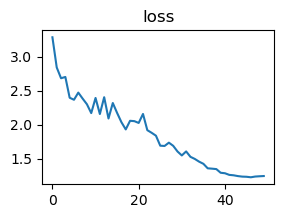

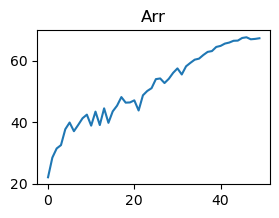

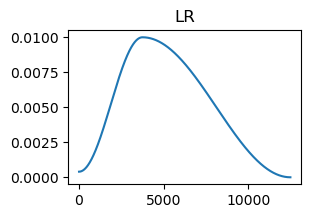

In [7]:
plt.figure(figsize=(3, 2))
plt.plot(loss_arr)
plt.title('loss')

plt.figure(figsize=(3, 2))
plt.plot(acc_arr)
plt.title('Arr')

plt.figure(figsize=(3, 2))
plt.plot(lr_arr)
plt.title('LR')

In [8]:
PATH = './SKNet.pth'
torch.save(model.state_dict(), PATH)